In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
from google.colab import files
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
! pip install gdown
import gdown
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import the cleaned dataset
df = pd.read_csv('/content/customer_complaints_clean_vF.csv')
df.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [3]:
def generate_tfidf_dataframe(df_clean, max_features=1000):
    # Create a TFIDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
    # Fit the TFIDF vectorizer to the text data
    tfidf_data = vectorizer.fit_transform(df_clean['narrative'])
    feature_names = list(vectorizer.vocabulary_.keys())
    # Convert to create a df
    df_tfidf = pd.DataFrame(tfidf_data.toarray(), columns=feature_names)
    # Concatenate the original df with the new TF-IDF df
    df_tfidf_clean = pd.concat([df_clean, df_tfidf], axis=1)

    return df_tfidf_clean

In [4]:
# Apply tfidf function to create cleaned dataframe
df_tfidf_clean = generate_tfidf_dataframe(df)
df_tfidf_clean.head()

,product,narrative,purchase,order,day,receive,product,week,sent,email,...,navient,fine,veteran,tracking,wire,instruction,santander,exhibit,health,trans
0,credit_card,purchase order day shipping amount receive pro...,0.0,0.000000,0.0,0.0,0.0,0.0,0.061158,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,credit_card,forwarded message date tue subject please inve...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,retail_banking,forwarded message cc sent friday pdt subject f...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.057372,0.0,0.039958,0.0,0.0
3,credit_reporting,payment history missing credit report speciali...,0.0,0.113826,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,credit_reporting,payment history missing credit report made mis...,0.0,0.117199,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [5]:
# Subset and extract the relevant columns for modeling
X = df_tfidf_clean.drop(['product','narrative'], axis=1) # Extract the TFIDF columns for modeling
y = df_tfidf_clean.iloc[:, 0] # Extract the target 'product' column for modeling

In [6]:
# Train/test split the dataset for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Train a simple Random Forest (RF) classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Run a prediction on the test set using the trained RF classifier
y_pred = rfc.predict(X_test)

In [9]:
# Print the accuracy of the prediction from the RF classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8471411381968893


In [10]:
# Acquire the classification report of the RF classifier
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import f1_score, classification_report

print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

        credit_card       0.81      0.75      0.78      2978
   credit_reporting       0.85      0.93      0.89      8896
    debt_collection       0.85      0.76      0.80      4145
mortgages_and_loans       0.87      0.83      0.85      3760
     retail_banking       0.84      0.84      0.84      2660

           accuracy                           0.85     22439
          macro avg       0.84      0.82      0.83     22439
       weighted avg       0.85      0.85      0.85     22439



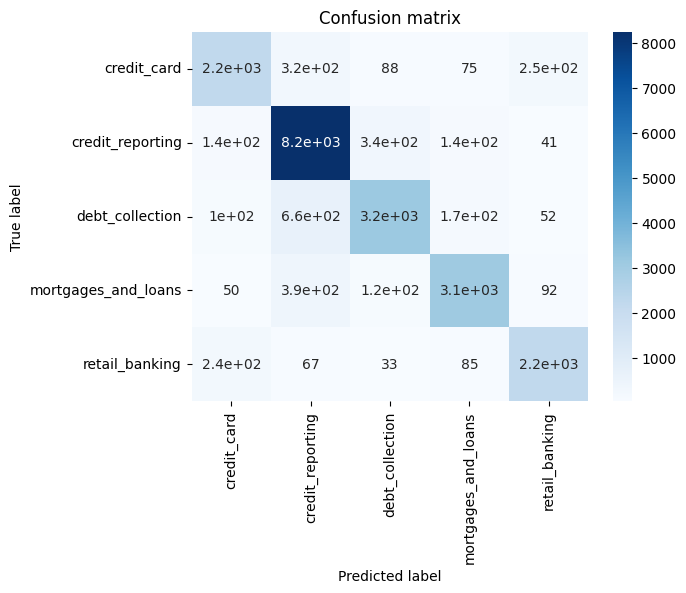

In [11]:
# Compute and plot the confusion matrix
labels = sorted(y.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)

sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()